# Research Question: Interplay between income and expenses?
How do households choose to organize their limited yearly income according to their shopping expenses? <br>
Can we infer different household types based on the relation between their income and transaction statistics? <br>
Are some demographic properties of the households indicators of this relation as well i.e. can we infer common family values indirectly from this data? <br>
To begin to answer these questions we first perform data exploration on the Dunnhumby dataset, to get initial insight for these tasks. 

In [55]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Loading the required files

In [66]:
households = pd.read_csv(r"dunnhumby\hh_demographic.csv", header=0)
households = households.set_index("household_key")
print("Number of households:", len(households))
households.head()

Number of households: 801


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown


In [67]:
transactions = pd.read_csv(r"dunnhumby\transaction_data.csv", header=0)
print("Number of transactions:", len(transactions))
transactions.head()

Number of transactions: 2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


For this research question, we will only require the data files `hh_demographic.csv` and `transaction_data.csv`. We observe that the dataset contains a large number of shopping transactions, although the number of households for which demographic information is present is smaller. In the dataset documentation is it explained that demographic information is not available for every household because of privacy reasons.

## Checking for missing and inconsistent data

In [63]:
print("Any columns with undefined values in household data:", any(households.isna().any(axis=0)))
print("Any columns with undefined values in transactions data:", any(transactions.isna().any(axis=0)))
transactions_invalid = transactions[(transactions["SALES_VALUE"] == 0) |
                                    (transactions["QUANTITY"] == 0)]
transactions_cleaned = transactions.drop(transactions_invalid.index)
print("Number of transactions removed:", len(transactions_invalid))

Any columns with undefined values in household data: False
Any columns with undefined values in transactions data: False
Number of transactions removed: 18917


When checking for missing values in the two tables we observed none. However, in the second table we observed that some transaction entries contain `0` as the value for the total amount received by the retailer and/or also `0` for the number of products purchased. There may be a valid reason why the data had been recorded this way, however we chose to avoid any assumptions and discard these transactions, as it is only a small percentage of the whole sample.   

## Analyzing distribution of household income

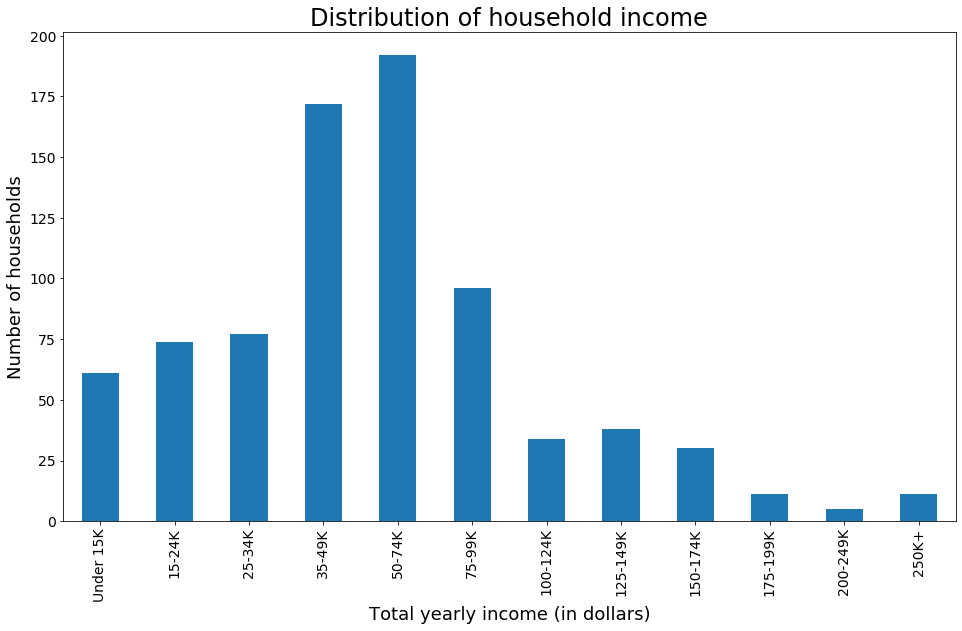

In [112]:
households_income = households["INCOME_DESC"]
income_categories = [
    "Under 15K", "15-24K", "25-34K", "35-49K", "50-74K", "75-99K", "100-124K",
    "125-149K", "150-174K", "175-199K", "200-249K", "250K+"
]
households_income = pd.Categorical(households_income,
                                   categories=income_categories,
                                   ordered=True)

plt.title("Distribution of household income", fontsize=24)
households_income.value_counts().plot.bar(figsize=(16, 9))
plt.xlabel("Total yearly income (in dollars)", fontsize=18)
plt.ylabel("Number of households", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The main feature of each household which we will analyze for this research question is the `INCOME_DESC` column. It holds information about the total yearly income for each household. The main challenge in answering the questions mentioned is the fact that this feature is not numeric - each income value is represented as a category which represents an interval of income values. Looking on the bright side, there is meaningful ordering of the categories as they are intervals. Looking at the barplot depicting the distribution of this feature we notice hints of a (bimodal) Gaussian distribution, however the discretization makes it impossible to verify.

## Inferring actual amount paid by customers for each transaction and actual product prices

In [23]:
transactions_cleaned["CUSTOMER_PAID"] = \
transactions_cleaned["SALES_VALUE"] + transactions_cleaned["COUPON_DISC"]
transactions_cleaned["PRODUCT_PRICE"] = (
    transactions_cleaned["SALES_VALUE"] -
    (transactions_cleaned["RETAIL_DISC"] +
     transactions_cleaned["COUPON_MATCH_DISC"])
) / transactions_cleaned["QUANTITY"]

Using the formulas given in the dataset documentation, we can compute the values which we will the most useful for our analysis.

## Merging household and transaction data

In [25]:
households_transactions = households.merge(transactions_cleaned,
                                           how="inner",
                                           on="household_key")
print("Number of transactions for the selected households:",
      households_transactions.shape[0])

Number of transactions for the selected households: 1416672


We join the two tables to obtain the transactions for each household that we have demographic data for. After this the number of useful transactions has been reduced by about a half, however we still remain in the range of half a million transactions. 

## Analyzing distribution of average bill amount

In [79]:
households_total_basket_payments = households_transactions.groupby(["household_key", "BASKET_ID"]).sum()["CUSTOMER_PAID"]
households_average_basket_payment = households_total_basket_payments.groupby("household_key").mean()

Median: 32.2431


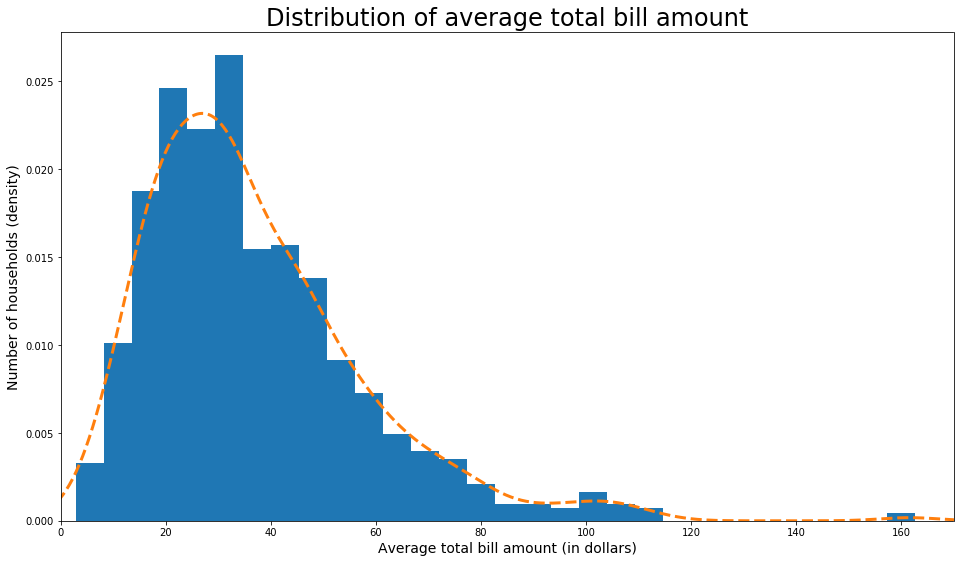

In [86]:
print("Median:", households_average_basket_payment.median().round(4))

plt.figure(figsize=(16, 9))
plt.hist(households_average_basket_payment, bins="auto", density=True)
households_average_basket_payment.plot(kind="density", linestyle="--", lw=3)
plt.xlim(0, 170)
plt.title("Distribution of average total bill amount", fontsize=24)
plt.xlabel("Average total bill amount (in dollars)", fontsize=14)
plt.ylabel("Number of households (density)", fontsize=14)
plt.show()

To measure the spending habits of the households, as a first metric we compute the average total amount of household's supermarket bills. Each household visit to a store is uniquely identified with a `BASKET_ID`. So first we sum the derived `CUSTOMER_PAID` column across the transactions for each visit to get the total bill amount for the visit. Then this is averaged across all visits of each household. Looking at the histogram of this statistic we identify it as a right-skewed Gaussian distribution, with a few outliers.

## Analyzing distribution of average price of most expensive product bought

In [87]:
households_basket_max_product_price = households_transactions.groupby(["household_key", "BASKET_ID"]).max()["PRODUCT_PRICE"]
households_max_product_price = households_basket_max_product_price.groupby("household_key").mean()

Median: 6.512


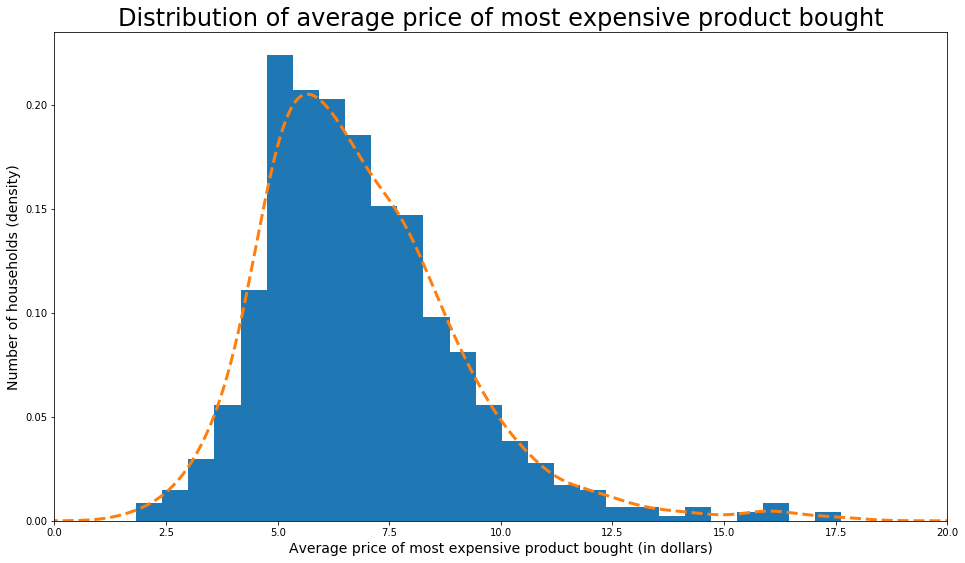

In [88]:
print("Median:", households_max_product_price.median().round(4))

plt.figure(figsize=(16, 9))
plt.hist(households_max_product_price, bins="auto", density=True)
households_max_product_price.plot.density(linestyle="--", lw=3)
plt.xlim(0, 20)
plt.title("Distribution of average price of most expensive product bought",
          fontsize=24)
plt.xlabel("Average price of most expensive product bought (in dollars)",
           fontsize=14)
plt.ylabel("Number of households (density)", fontsize=14)
plt.show()

From another perspective, we can calculate a different statistic quantifying the spending habits of each household. This time we use the derived actual prices of each of the products in the basket (`PRODUCT_PRICE`) to calculate the maximum product price in each basket and then as previously, average across for each household. We observe from its histogram that this feature has a much more regular Gaussian distribution.

# Comparing the two statistics

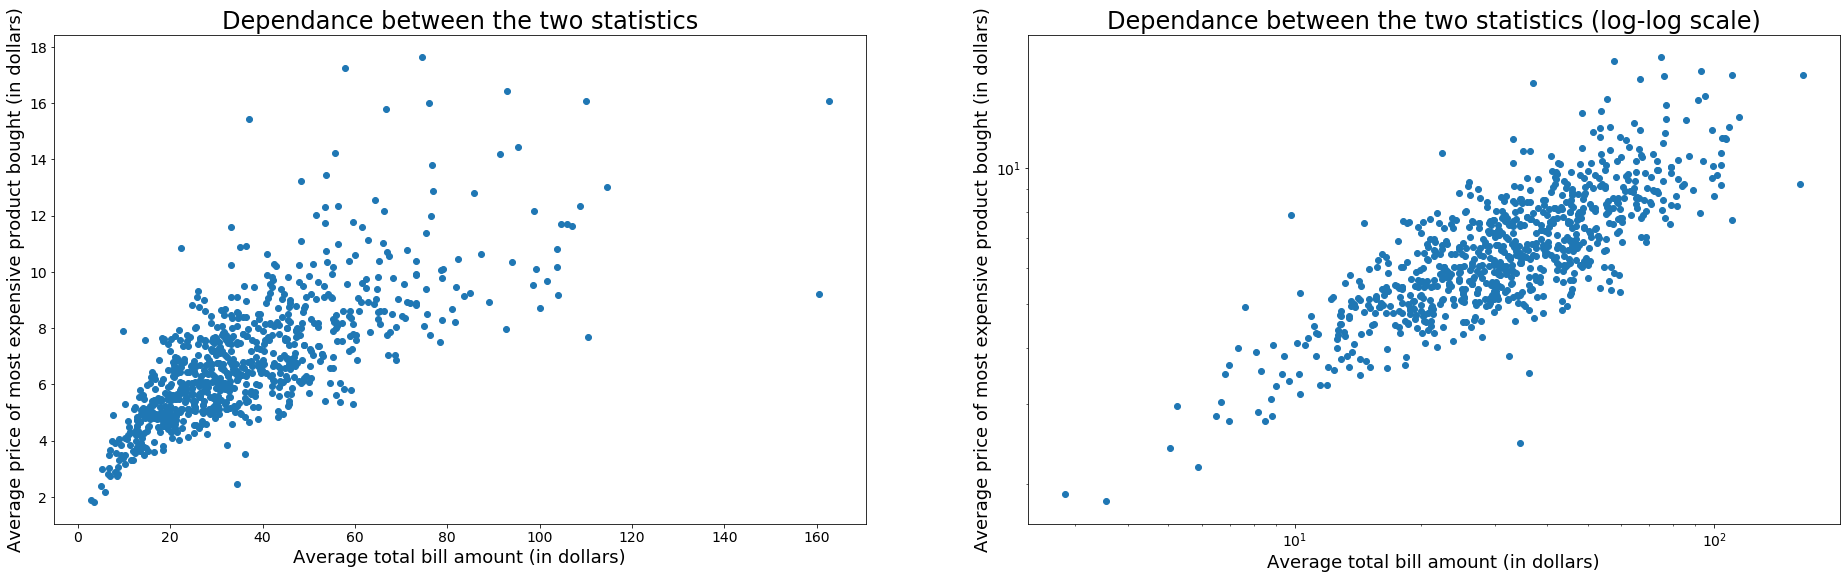

In [96]:
plt.figure(figsize=(16 * 2, 9))

plt.subplot(121)
plt.scatter(households_average_basket_payment, households_max_product_price)
plt.title("Dependance between the two statistics", fontsize=24)
plt.xlabel("Average total bill amount (in dollars)", fontsize=18)
plt.ylabel("Average price of most expensive product bought (in dollars)",
           fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.scatter(households_average_basket_payment, households_max_product_price)
plt.xscale("log")
plt.yscale("log")
plt.title("Dependance between the two statistics (log-log scale)", fontsize=24)
plt.xlabel("Average total bill amount (in dollars)", fontsize=18)
plt.ylabel("Average price of most expensive product bought (in dollars)",
           fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Using a scatter plot we test the existence of dependence between the two statistics. When using linear scales no obvious correlation is visible, however when viewing the data in log-log scales we can discern a linear trend, albeit with a relatively large variance. This suggests that the statistics might be almost equivalent (after some nonlinear transformation) and can be used interchangeably. We will support this further with the analyses in the following sections.

## Comparing household income with average bill amount

In [102]:
households_income_df = pd.DataFrame(
    pd.Series(households_income,
              name="INCOME_DESC",
              index=households.index))
households_income_df.index.name = "household_key"
households_income_average_basket_payment = households_income_df.join(households_average_basket_payment, how="inner")

To begin the comparison between household income and average bill amount we first merge the two features of each household.

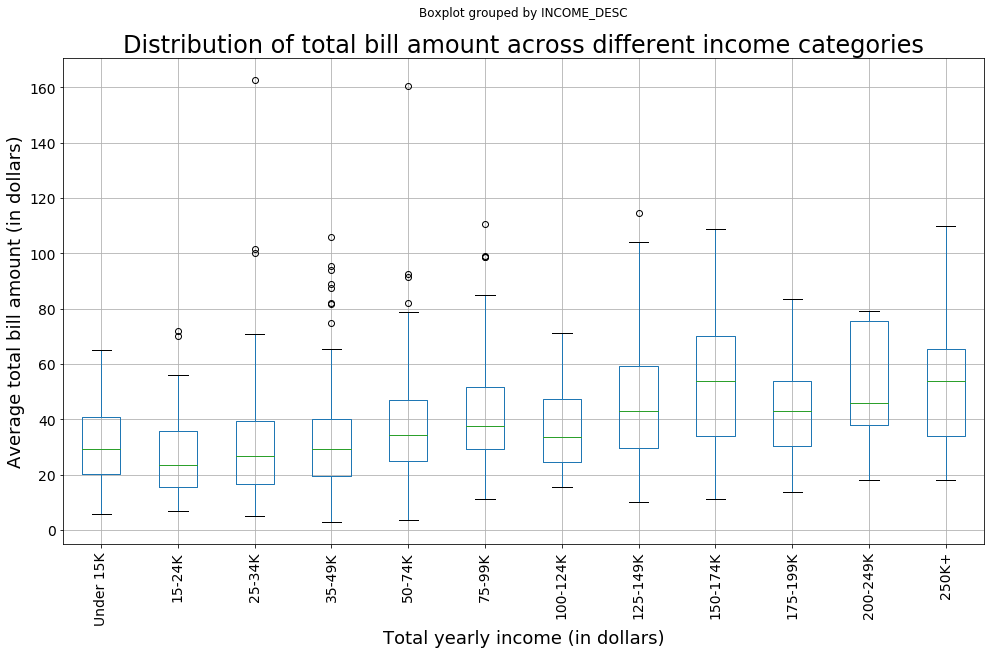

In [104]:
households_income_average_basket_payment.boxplot(by="INCOME_DESC",
                                                 column="CUSTOMER_PAID",
                                                 figsize=(16, 9))
plt.xticks(rotation=90)
plt.title(
    "Distribution of total bill amount across different income categories",
    fontsize=24)
plt.xlabel("Total yearly income (in dollars)", fontsize=18)
plt.ylabel("Average total bill amount (in dollars)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Using a boxplot we can view the distribution of the statistic across each household income category and perform a comparison very efficiently. Unfortunately however, we can see that the values of the statistic are very similar both in median and min-max range for every income interval. Interestingly though, extreme spending values are mostly observed for medium and lower income households. 

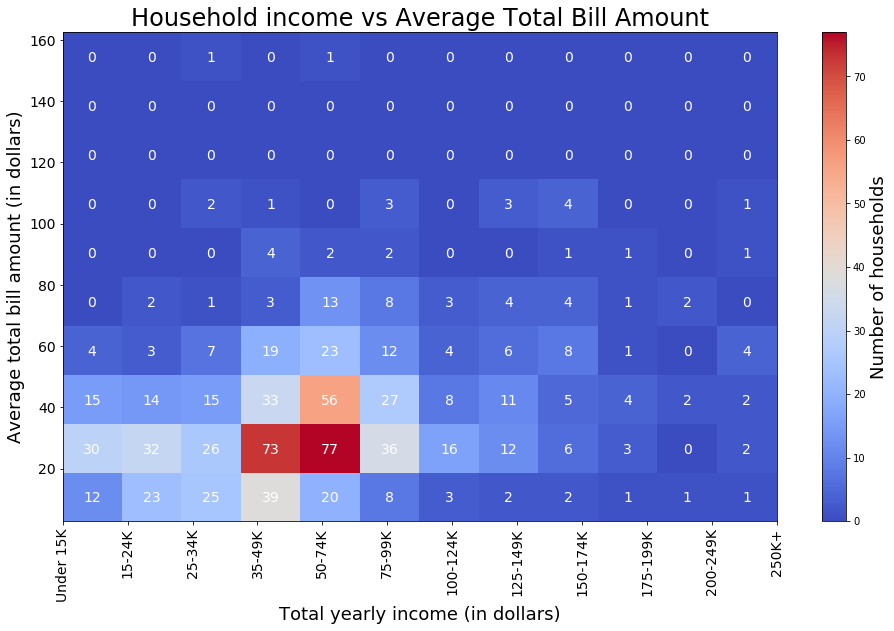

In [110]:
plt.figure(figsize=(16, 9))
plt.title("Household income vs Average Total Bill Amount", fontsize=24)
hist, xbins, ybins, _ = plt.hist2d(households_income_df.INCOME_DESC.cat.codes,
                                   households_average_basket_payment,
                                   bins=[len(income_categories), 10],
                                   cmap="coolwarm")
plt.xticks(range(len(income_categories)),
           households_income.categories.to_list(),
           rotation=90)
plt.xlabel("Total yearly income (in dollars)", fontsize=18)
plt.ylabel("Average total bill amount (in dollars)", fontsize=18)
for i in range(len(ybins) - 1):
    for j in range(len(xbins) - 1):
        plt.text(xbins[j] + 0.45,
                 ybins[i] + 7.5,
                 int(hist[j, i]),
                 ha="center",
                 va="center",
                 color="w",
                 fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar().set_label(label="Number of households", size=18)
plt.show()

Using a 2D histogram i.e. heatmap we can compare the relation between income and the statistic in more detail by viewing their joint distribution. We can observe that the majority of the households are concentrated at the medium income values of 35-74K and lower average expenses of about 20-40 dollars.

## Comparing household income with average price of most expensive product bought

In [42]:
households_income_max_product_price = households_income_df.join(households_max_product_price, how="inner")

Similarly, to begin the comparison between household income and maximum product prices we first merge the two features of each household.

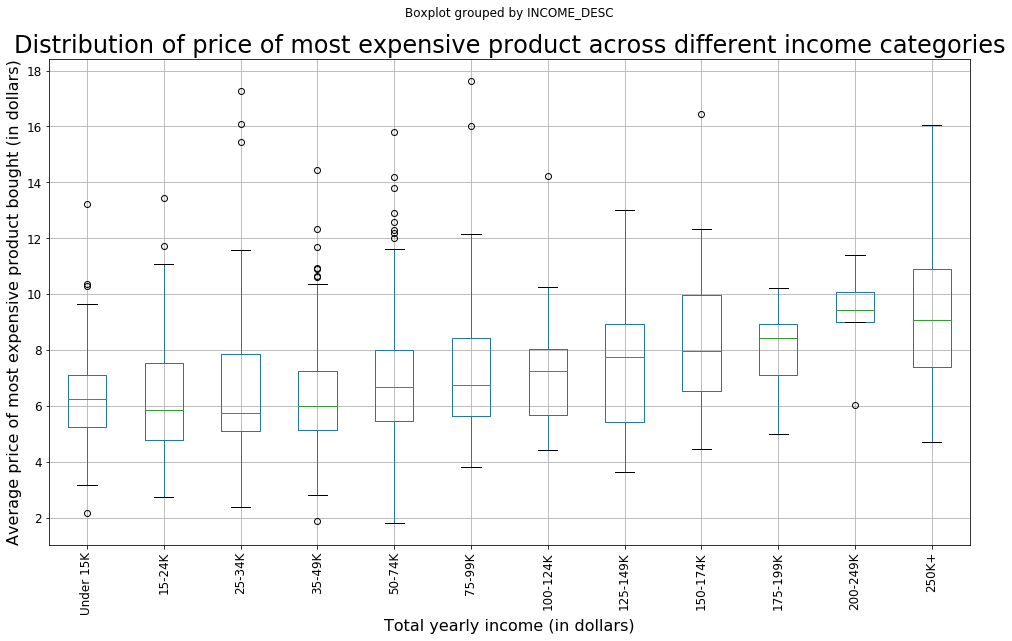

In [111]:
households_income_max_product_price.boxplot(by="INCOME_DESC",
                                            column="PRODUCT_PRICE",
                                            figsize=(16, 9))
plt.xticks(rotation=90)
plt.title(
    "Distribution of price of most expensive product across different income categories",
    fontsize=24)
plt.xlabel("Total yearly income (in dollars)", fontsize=16)
plt.ylabel("Average price of most expensive product bought (in dollars)",
           fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The boxplot for the second statistic also displays the issue of the low variance of the median value across the income categories as well. The phenomena related to the extreme values is present here as well, but here additionally an interesting difference is the huge range of values for the richest households, perhaps capturing the fact that mostly these households purchase the most expensive products.

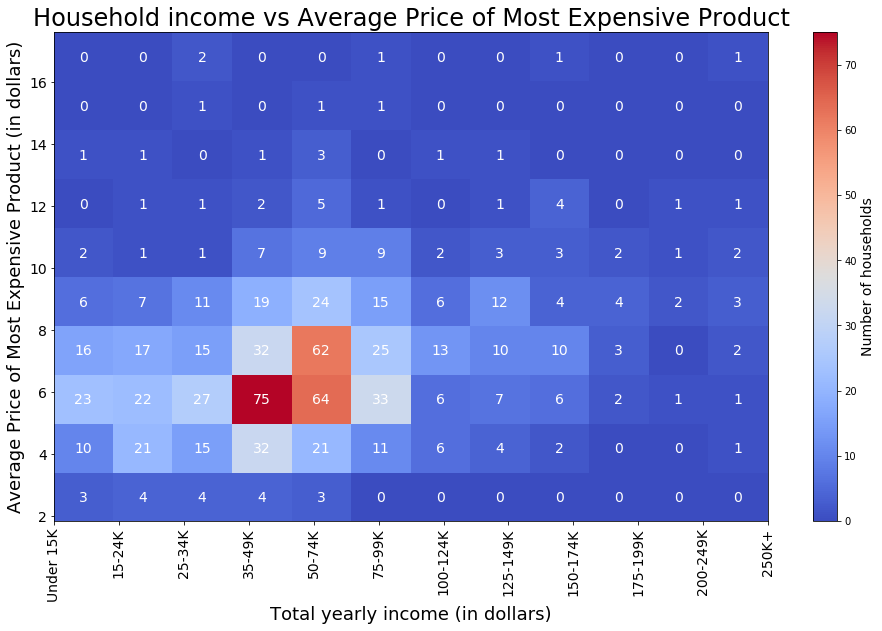

In [43]:
plt.figure(figsize=(16, 9))
plt.title("Household income vs Average Price of Most Expensive Product",
          fontsize=24)
hist, xbins, ybins, _ = plt.hist2d(households_income_df.INCOME_DESC.cat.codes,
                                   households_max_product_price,
                                   bins=[len(income_categories), 10],
                                   cmap="coolwarm")
plt.xticks(range(len(income_categories)),
           households_income.categories.to_list(),
           rotation=90)
plt.xlabel("Total yearly income (in dollars)", fontsize=18)
plt.ylabel("Average Price of Most Expensive Product (in dollars)", fontsize=18)
for i in range(len(ybins) - 1):
    for j in range(len(xbins) - 1):
        plt.text(xbins[j] + 0.45,
                 ybins[i] + 0.75,
                 int(hist[j, i]),
                 ha="center",
                 va="center",
                 color="w",
                 fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar().set_label(label="Number of households", size=14)
plt.show()

Analyzing the joint distribution using the heatmap, we observe that it is very similar in form to the one for the previous statistic, further proving their equivalence.

## Split households into 4 groups based on income and expenses

In [47]:
average_income = "50-74K"
average_expenses = 32.2431

df = households.drop("INCOME_DESC",
                     axis=1).join(households_income_average_basket_payment,
                                  how="inner",
                                  on="household_key")
households_low_income_low_expenses = df[
    (df["INCOME_DESC"] <= average_income)
    & (df["CUSTOMER_PAID"] <= average_expenses)]
households_low_income_high_expenses = df[
    (df["INCOME_DESC"] <= average_income)
    & (df["CUSTOMER_PAID"] > average_expenses)]
households_high_income_low_expenses = df[
    (df["INCOME_DESC"] > average_income)
    & (df["CUSTOMER_PAID"] <= average_expenses)]
households_high_income_high_expenses = df[
    (df["INCOME_DESC"] > average_income)
    & (df["CUSTOMER_PAID"] > average_expenses)]

print("Percent of households with low income and low expenses:",
      round(len(households_low_income_low_expenses) / len(households), 4))
print("Percent of households with low income and high expenses:",
      round(len(households_low_income_high_expenses) / len(households), 4))
print("Percent of households with high income and low expenses:",
      round(len(households_high_income_low_expenses) / len(households), 4))
print("Percent of households with high income and high expenses:",
      round(len(households_high_income_high_expenses) / len(households), 4))

Percent of households with low income and low expenses: 0.4082
Percent of households with low income and high expenses: 0.3109
Percent of households with high income and low expenses: 0.0924
Percent of households with high income and high expenses: 0.1885


## Compare demographic attributes of each household group

In [48]:
def demographic_analysis_of_household_groups(column_name, demographic_categories, demographic_feature_name):
    df1 = households_low_income_low_expenses[column_name].value_counts().rename("LOW_INCOME_LOW_EXPENSES") / len(households_low_income_low_expenses)
    df2 = households_low_income_high_expenses[column_name].value_counts().rename("LOW_INCOME_HIGH_EXPENSES") / len(households_low_income_high_expenses)
    df3 = households_high_income_low_expenses[column_name].value_counts().rename("HIGH_INCOME_LOW_EXPENSES") / len(households_high_income_low_expenses)
    df4 = households_high_income_high_expenses[column_name].value_counts().rename("HIGH_INCOME_HIGH_EXPENSES") / len(households_high_income_high_expenses)
    demographic_df=pd.concat((df1,df2,df3,df4), axis=1, sort=False)
    demographic_df.index = demographic_categories
    demographic_df.plot.bar(figsize=(16,9))
    plt.title("Demographic analysis of household groups - {}".format(demographic_feature_name), fontsize=24)
    plt.xlabel(demographic_feature_name, fontsize=18)
    plt.ylabel("Percentage of households in group", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

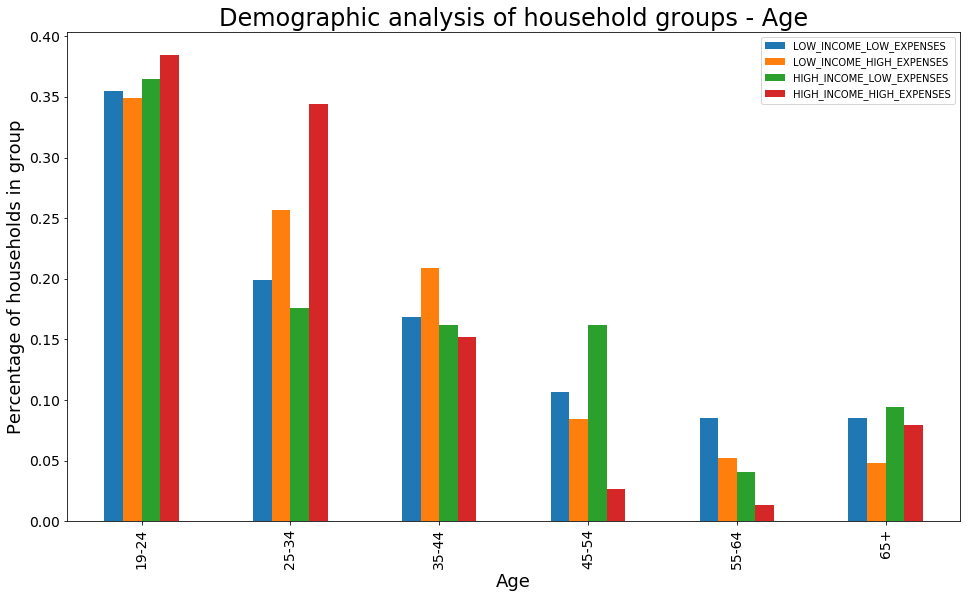

In [49]:
age_categories = ["19-24", "25-34", "35-44", "45-54", "55-64", "65+"]
demographic_analysis_of_household_groups("AGE_DESC", age_categories, "Age")

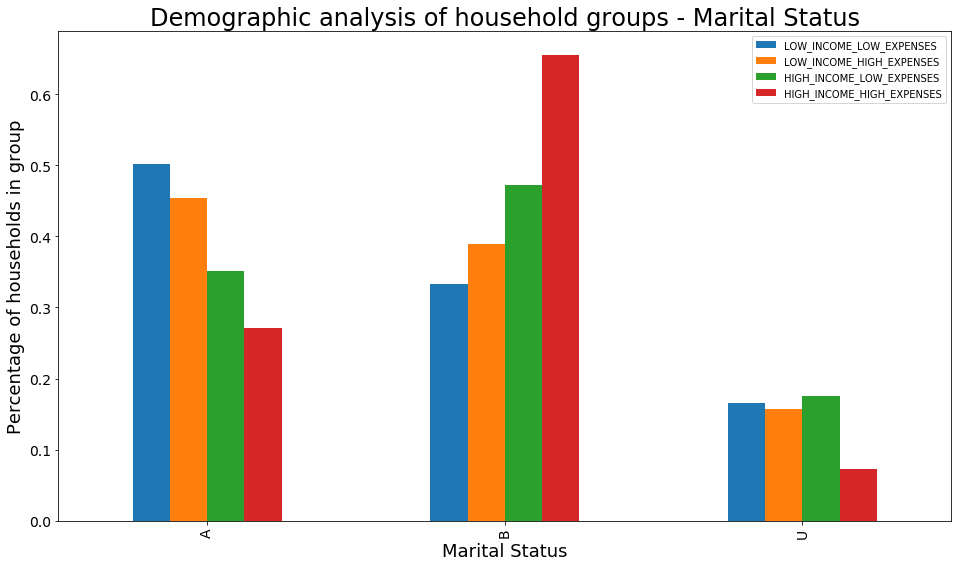

In [50]:
marital_status_categories = ["A", "B", "U"]
demographic_analysis_of_household_groups("MARITAL_STATUS_CODE",
                                         marital_status_categories,
                                         "Marital Status")

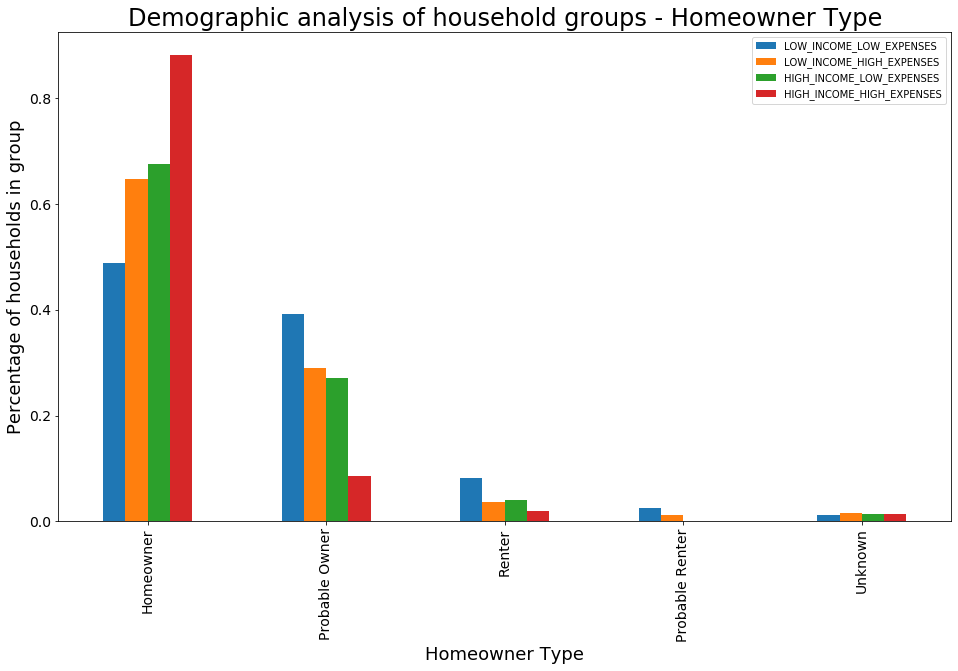

In [51]:
homeowner_type_categories = [
    "Homeowner", "Probable Owner", "Renter", "Probable Renter", "Unknown"
]
demographic_analysis_of_household_groups("HOMEOWNER_DESC",
                                         homeowner_type_categories,
                                         "Homeowner Type")

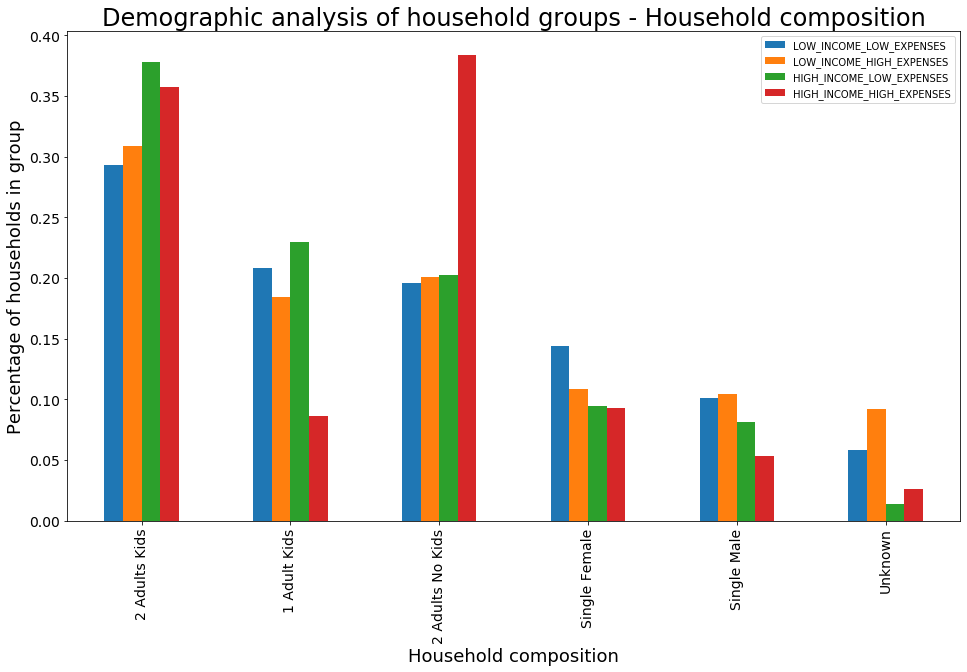

In [52]:
household_composition_categories = [
    "2 Adults Kids", "1 Adult Kids", "2 Adults No Kids", "Single Female",
    "Single Male", "Unknown"
]
demographic_analysis_of_household_groups("HH_COMP_DESC",
                                         household_composition_categories,
                                         "Household composition")

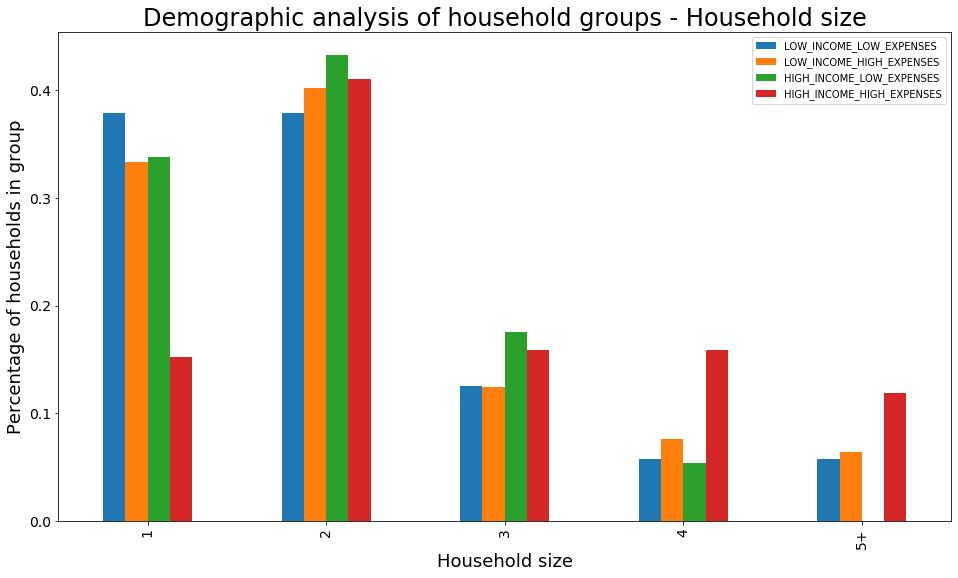

In [53]:
household_size_categories = ["1", "2", "3", "4", "5+"]
demographic_analysis_of_household_groups("HOUSEHOLD_SIZE_DESC",
                                         household_size_categories,
                                         "Household size")

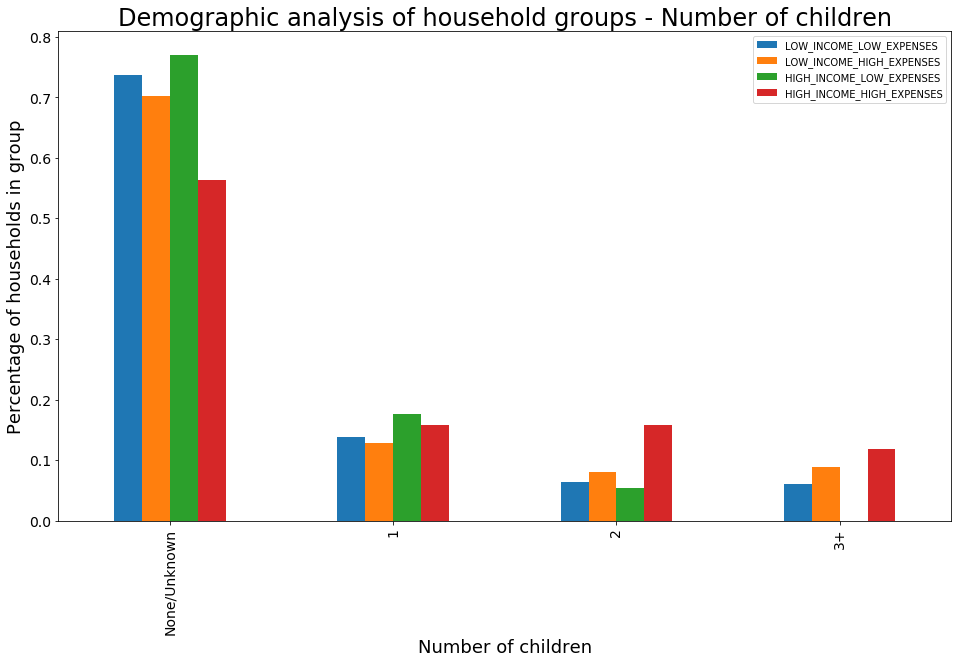

In [54]:
number_of_children_categories = ["None/Unknown", "1", "2", "3+"]
demographic_analysis_of_household_groups("KID_CATEGORY_DESC",
                                         number_of_children_categories,
                                         "Number of children")

In [ ]:
def analyze_demographic_of_household_group(households_group):
    plt.figure(figsize=(16 * 2, 9 * 3))

    plt.subplot(321)
    households_group.AGE_DESC.value_counts().plot.bar()
    plt.title("Distribution of age", fontsize=28)
    plt.xlabel("Household age range (in years)", fontsize=24)
    plt.ylabel("Number of households", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.subplot(322)
    households_group.MARITAL_STATUS_CODE.value_counts().plot.bar()
    plt.title("Distribution of marital status", fontsize=28)
    plt.xlabel("Marital status", fontsize=24)
    plt.ylabel("Number of households", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.subplot(323)
    households_group.HOMEOWNER_DESC.value_counts().plot.bar()
    plt.title("Distribution of homeowner type", fontsize=28)
    plt.xlabel("Homeowner type", fontsize=24)
    plt.ylabel("Number of households", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.subplot(324)
    households_group.HH_COMP_DESC.value_counts().plot.bar()
    plt.title("Distribution of household composition", fontsize=28)
    plt.xlabel("Household composition", fontsize=24)
    plt.ylabel("Number of households", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.subplot(325)
    households_group.HOUSEHOLD_SIZE_DESC.value_counts().plot.bar()
    plt.title("Distribution of household size", fontsize=28)
    plt.xlabel("Household size", fontsize=24)
    plt.ylabel("Number of households", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.subplot(326)
    households_group.KID_CATEGORY_DESC.value_counts().plot.bar()
    plt.title("Distribution of number of children", fontsize=28)
    plt.xlabel("Number of children", fontsize=24)
    plt.ylabel("Number of households", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.tight_layout()

    plt.show()